In [3]:
import torch
from jetnet_dataloader import JetNetDataloader
from lit_nf import TransGan
from plotting import *
import pandas as pd
from jetnet.evaluation import w1p, w1efp, w1m, cov_mmd,fpnd
from jetnet.datasets import JetNet
from main import train
pd.set_option("display.max_colwidth",200)
import matplotlib.pyplot as plt
import os
import hist
import mplhep as hep
import torch
import numpy as np
import hist
from hist import Hist
import traceback
from helpers import mass
import pandas as pd

from mpl_toolkits.axes_grid1 import make_axes_locatable
class plotting_paper():
    '''This is a class that takes care of  plotting steps in the script,
        It is initialized with the following arguments:
        true=the simulated data, note that it needs to be scaled
        gen= Generated data , needs to be scaled
        step=The current step of the training, this is need for tensorboard
        model=the model that is trained, a bit of an overkill as it is only used to access the losses
        config=the config used for training
        logger=The logger used for tensorboard logging'''
    def __init__(self,true,gen,config,step,p,model=None,logger=None,weight=1):
        self.config=model.config
        self.n_dim=self.config["n_dim"]
        self.gen=gen
        self.test_set=true
        self.step=step
        self.model=model
        self.p=p

        self.weight=weight
        if logger is not None:
            self.summary=logger
    def plot_mass_only(self,m,m_t,bins=15):
        fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]},figsize=(6,8))
        a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
        b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
        a=np.quantile(m_t,0.001)
        b=np.quantile(m_t,0.999)
        h=hist.Hist(hist.axis.Regular(bins,a,b))
        h2=hist.Hist(hist.axis.Regular(bins,a,b))
        bins = h.axes[0].edges
        h.fill(m)#,weight=1/self.weight)
        h2.fill(m_t)
            
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )

        main_ax_artists, sublot_ax_arists = h.plot_ratio(
            h2,
            ax_dict={"main_ax":ax[0],"ratio_ax":ax[1]},
            rp_ylabel=r"Ratio",
            rp_num_label="Flow Generated",
            rp_denom_label="MC Simulatied",
            rp_uncert_draw_type="line",  # line or bar
        )
        ax[0].set_xlabel("")
#                 if quantile and v=="m" and plot_vline:
#                     ax[0,k].hist(m[m_t<np.quantile(m_t,0.1)],histtype='step',bins=bins,alpha=1,color="red",label="10% quantile gen",hatch="/")
#                     ax[0,k].vlines(np.quantile(m_t,0.1),0,np.max(h[:]),color="red",label='10% quantile train')

        ax[1].set_ylim(0.25,2)
        ax[0].set_xlim(a,b)
        ax[1].set_xlabel("$m_T$",fontweight="bold")
        ax[1].set_xlim(a,b)
        ax[0].set_ylabel("Counts",fontweight="bold" )
        ax[1].set_ylabel("Ratio",fontweight="bold")
  
     
#             print("added figure")
#             self.summary.close()

        plt.savefig("{}_mass".format(self.p))
        plt.show()

    def plot_marginals(self,ith=None,save=False,title=None):
        #This plots the marginal distribution for simulation and generation
        #Note that this is the data the model sees during training as input to model in the NF
        #This is the distribution of one of [eta,phi,pt] of one particle of the n particles per jet: for example the pt of the 3rd particle
        #if save, the histograms are logged to tensorboard otherwise they are shown
        
        plt.switch_backend('agg')
        name,label=["eta","phi","pt"],['${\eta}^{rel}_{7}$',"${\phi}^{rel}_{7}$","${p_T}^{rel}_{7}$"]
        fig,ax=plt.subplots(2,3,gridspec_kw={'height_ratios': [3, 1]},figsize=(18,6))
        particles=range(self.n_dim) if not ith else [3*ith,3*ith+1,3*ith+2]
        plt.suptitle(title,fontweight="bold")
        k=0
        for i in particles:
            if ith:
                ax_temp=ax[:,k]
            else:
                fig,ax_temp=plt.subplots(2,1)
            a=np.quantile(self.test_set[:,i].numpy(),0)
            b=np.quantile(self.test_set[:,i].numpy(),1)

            h=hist.Hist(hist.axis.Regular(15,a,b,label=label[i%3],underflow=False,overflow=False))
            h2=hist.Hist(hist.axis.Regular(15,a,b,label=label[i%3],underflow=False,overflow=False))
            h.fill(self.gen[:,i].numpy())
            h2.fill(self.test_set[:,i].numpy())
            
            plt.tight_layout()
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0,k] )
       
            main_ax_artists, sublot_ax_arists = h.plot_ratio(
                h2,
                ax_dict={"main_ax":ax_temp[0],"ratio_ax":ax_temp[1]},
                rp_ylabel=r"Ratio",
#                 rp_xlabel=label[i%3],
                rp_num_label="Flow Generated",
                rp_denom_label="MC Simulated",
                rp_uncert_draw_type="line",  # line or bar
            )
            
            
            ax_temp[0].set_xlabel("")
            ax_temp[1].set_ylim(0.25,2)
            ax_temp[0].set_xlim(a,b)
            ax_temp[1].set_xlim(a,b)
            ax_temp[1].set_xlabel(label[i%3])
            ax_temp[0].set_ylabel("Counts",fontweight="bold" )
            ax_temp[1].set_ylabel("Ratio",fontweight="bold")
            
            
            #plt.tight_layout(pad=2)
            k+=1
        if save:
            self.summary.add_figure("jet{}_{}".format(i//3+1,name[i%3]),fig,global_step=self.step)
            self.summary.close()
        else:
            plt.savefig("{}_7thpart".format(self.p))
            plt.show()


    def plot_2d(self,save=False):
        #This creates a 2D histogram of the inclusive distribution for all 3 feature combinations
        #Inclusive means that is the distribution of pt of all particles per jet and sample
        #if save, the histograms are logged to tensorboard otherwise they are shown
        data=self.test_set[:,:self.n_dim].reshape(-1,3).numpy()
        gen=self.gen[:,:self.n_dim].reshape(-1,3).numpy()
        labels=[r"$\eta^{rel}$",r"$\phi^{rel}_7$",r"$p_T^{rel}$"]
        names=["eta","phi","pt"]
        for index in [[0,1],[0,2],[1,2]]:
            
            fig,ax=plt.subplots(ncols=2,figsize=(16, 8))
            _,x,y,_=ax[0].hist2d(data[:,index[0]],data[:,index[1]],bins=30)
            #rebin to only take 5% to 95.0% of signal dis
            a=np.quantile(x,0.05)
            b=np.quantile(x,0.95)
            x=np.linspace(a,b,len(x))
            a=np.quantile(y,0.05)
            b=np.quantile(y,0.95)
            y=np.linspace(a,b,len(y))
            if index[1]==2:
                y=np.abs(y)+0.00001
                y = np.logspace(np.log(y[0]),np.log(y[-1]),len(y))
            ax[0].hist2d(data[:,index[0]],data[:,index[1]],bins=[x,y])
            data[:,index[0]]=np.abs(data[:,index[0]])+0.00001
            ax[1].hist2d(gen[:,index[0]],gen[:,index[1]],bins=[x,y])
        
        
            plt.tight_layout(pad=2)
            ax[0].set_xlabel( labels[index[0]],fontweight="bold")
            ax[0].set_ylabel( labels[index[1]],fontweight="bold")
            
            ax[0].set_title("MC Simulated")
            ax[1].set_xlabel( labels[index[0]],fontweight="bold")
            ax[1].set_ylabel( labels[index[1]],fontweight="bold")
            
            ax[1].set_title("Flow Generated")
           
            if save:
                self.summary.add_figure("2d{}-{}".format(names[index[0]],names[index[1]]),fig,global_step=self.step)
                
                # self.summary.close()
            else:
                plt.savefig("{}_2dcorr{}{}".format(self.p,names[index[0]],names[index[0]]))
                plt.show()
                
 
        
    def oversample(self,m,m_t,weight,save=False,quantile=False,bins=15,plot_vline=False,title=""):
        #This creates a histogram of the inclusive distributions and calculates the mass of each jet
        #and creates a histogram of that
        #if save, the histograms are logged to tensorboard otherwise they are shown
        #if quantile, this also creates a histogram of a subsample of the generated data, 
        # where the mass used to condition the flow is in the first 10% percentile of the simulated mass dist
        i=0
        k=0
        fig,ax=plt.subplots(2,4,gridspec_kw={'height_ratios': [3, 1]},figsize=(20,5))
        plt.suptitle(title,fontweight="bold")
        for v,name in zip(["eta","phi","pt","m"],[r"$\eta^{rel}$",r"$\phi^{rel}$",r"$p_T^{rel}$",r"$m^{rel}$"]):
            
            if v!="m":
                a=min(np.quantile(self.gen[:,i],0.001),np.quantile(self.test_set[:,i],0.001))
                b=max(np.quantile(self.gen[:,i],0.999),np.quantile(self.test_set[:,i],0.999))     
                
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                h.fill(self.gen[:,i],weight=1/weight)
                h2.fill(self.test_set[:,i])
                i+=1
            else:
                a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
                b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
                a=np.quantile(m_t,0.001)
                b=np.quantile(m_t,0.999)
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                bins = h.axes[0].edges
                h.fill(m,weight=1/weight)#,weight=1/self.weight)
                h2.fill(m_t)
            
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            try:
                main_ax_artists, sublot_ax_arists = h.plot_ratio(
                    h2,
                    ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
                    rp_ylabel=r"Ratio",
                    rp_num_label="Flow Generated",
                    rp_denom_label="MC Simulatied",
                    rp_uncert_draw_type="line",  # line or bar
                )
                ax[0,k].set_xlabel("")
#                 if quantile and v=="m" and plot_vline:
#                     ax[0,k].hist(m[m_t<np.quantile(m_t,0.1)],histtype='step',bins=bins,alpha=1,color="red",label="10% quantile gen",hatch="/")
#                     ax[0,k].vlines(np.quantile(m_t,0.1),0,np.max(h[:]),color="red",label='10% quantile train')
                    
                ax[1,k].set_ylim(0.25,2)
                ax[0,k].set_xlim(a,b)
                ax[1,k].set_xlabel(name,fontweight="bold")
                ax[1,k].set_xlim(a,b)
                ax[0,k].set_ylabel("Counts",fontweight="bold" )
                ax[1,k].set_ylabel("Ratio",fontweight="bold")
                
#                 if plot_vline:
#                        ax[0,k].legend(["Generated","Training","10% quantile Gen","10% quantile Sim"] )
#                 else:
#                       ax[0,k].legend(["Flow Generated","MC Simulated"] )
            except:
                print("mass plot failed reverting to simple plot mass bins")
                plt.close()
                plt.figure()
                _,b,_=plt.hist(m_t,15,label="MC Simulated",alpha=0.5)
                plt.hist(m,b,label="Flow Generated",alpha=0.5)
                plt.legend()  
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            
#             plt.xlabel(name)
            plt.tight_layout(pad=1)
            k+=1
        if save:
            if v!="m":
                 self.summary.add_figure("inclusive"+v,fig,self.step)
            else:
                self.summary.add_figure("jet_mass",fig,self.step)
#             print("added figure")
#             self.summary.close()
        else:
            plt.savefig("{}_oversample_{}".format(self.p,v))
            plt.show()

            
    def plot_mass(self,m,m_t,save=False,quantile=False,bins=15,plot_vline=False,title=""):
        #This creates a histogram of the inclusive distributions and calculates the mass of each jet
        #and creates a histogram of that
        #if save, the histograms are logged to tensorboard otherwise they are shown
        #if quantile, this also creates a histogram of a subsample of the generated data, 
        # where the mass used to condition the flow is in the first 10% percentile of the simulated mass dist
        i=0
        k=0
        fig,ax=plt.subplots(2,4,gridspec_kw={'height_ratios': [3, 1]},figsize=(20,5))
        plt.suptitle(title,fontweight="bold")
        for v,name in zip(["eta","phi","pt","m"],[r"$\eta^{rel}$",r"$\phi^{rel}$",r"$p_T^{rel}$",r"$m^{rel}$"]):
            
            if v!="m":
                a=min(np.quantile(self.gen[:,i],0.001),np.quantile(self.test_set[:,i],0.001))
                b=max(np.quantile(self.gen[:,i],0.999),np.quantile(self.test_set[:,i],0.999))     
                
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                h.fill(self.gen[:,i],weight=1/self.weight)
                h2.fill(self.test_set[:,i])
                i+=1
            else:
                a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
                b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
                a=np.quantile(m_t,0.001)
                b=np.quantile(m_t,0.999)
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                bins = h.axes[0].edges
                h.fill(m)#,weight=1/self.weight)
                h2.fill(m_t)
            
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            try:
                main_ax_artists, sublot_ax_arists = h.plot_ratio(
                    h2,
                    ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
                    rp_ylabel=r"Ratio",
                    rp_num_label="Flow Generated",
                    rp_denom_label="MC Simulatied",
                    rp_uncert_draw_type="line",  # line or bar
                )
                ax[0,k].set_xlabel("")
#                 if quantile and v=="m" and plot_vline:
#                     ax[0,k].hist(m[m_t<np.quantile(m_t,0.1)],histtype='step',bins=bins,alpha=1,color="red",label="10% quantile gen",hatch="/")
#                     ax[0,k].vlines(np.quantile(m_t,0.1),0,np.max(h[:]),color="red",label='10% quantile train')
                    
                ax[1,k].set_ylim(0.25,2)
                ax[0,k].set_xlim(a,b)
                ax[1,k].set_xlabel(name,fontweight="bold")
                ax[1,k].set_xlim(a,b)
                ax[0,k].set_ylabel("Counts",fontweight="bold" )
                ax[1,k].set_ylabel("Ratio",fontweight="bold")
                
#                 if plot_vline:
#                        ax[0,k].legend(["Generated","Training","10% quantile Gen","10% quantile Sim"] )
#                 else:
#                       ax[0,k].legend(["Flow Generated","MC Simulated"] )
            except:
                print("mass plot failed reverting to simple plot mass bins")
                plt.close()
                plt.figure()
                _,b,_=plt.hist(m_t,15,label="MC Simulated",alpha=0.5)
                plt.hist(m,b,label="Flow Generated",alpha=0.5)
                plt.legend()  
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            
#             plt.xlabel(name)
            plt.tight_layout(pad=1)
            k+=1
        if save:
            if v!="m":
                 self.summary.add_figure("inclusive"+v,fig,self.step)
            else:
                self.summary.add_figure("jet_mass",fig,self.step)
#             print("added figure")
#             self.summary.close()
        else:
            plt.savefig("{}_inclusive_{}".format(self.p,v))
            plt.show()


    def losses(self,save=False):
        '''This plots the different losses vs epochs'''
        fig=plt.figure()
        hep.cms.label("Private Work",data=None,lumi=None,year=None)
        plt.xlabel('step')
        plt.ylabel('loss')
        ln1=plt.plot(self.model.logprobs,label='log$(p_{gauss}(x_{data}))$')
        if "calc_massloss" in self.config.keys() and self.config["calc_massloss"]:
            plt.twinx()
            ln2=plt.plot(self.model.mlosses,label=r'mass mse $\times$ {}'.format(self.config["lambda"]),color='orange')
            plt.ylabel("MSE")
            plt.yscale("log")
            ln1+=ln2
        labs=[l.get_label() for l in ln1]
        plt.legend(ln1,labs)
        plt.tight_layout(pad=2)
        if save:
            self.summary.add_figure("losses",fig,self.step)
#             self.summary.close()
        else:
            plt.show()
   

    def plot_correlations(self,save=True):
        #Plots correlations between all particles for i=0 eta,i=1 phi,i=2 pt
        self.plot_corr(i=0,save=save)
        self.plot_corr(i=1,save=save)
        self.plot_corr(i=2,save=save)

    def plot_corr(self,i=0,names=["$\eta^{rel}$","$\phi^{rel}$","$p_T$"],save=True):
        if i==2:
            c=1
        else:
            c=1
        df_g=pd.DataFrame(self.gen.reshape(-1,90).detach().numpy()[:,range(i,90,3)])
        df_h=pd.DataFrame(self.test_set.reshape(-1,90).detach().numpy()[:,range(i,90,3)])
        fig,ax=plt.subplots(ncols=2,figsize=(20,10))
        corr_g = ax[0].matshow(df_g.corr())
        corr_g.set_clim(-c,c)
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar=fig.colorbar(corr_g,cax=cax)
        corr_h = ax[1].matshow(df_h.corr())
        corr_h.set_clim(-c,c)
        divider = make_axes_locatable(ax[1])
        cax2 = divider.append_axes('right', size='5%', pad=0.05)
        cbar=fig.colorbar(corr_h,cax=cax2)
        plt.suptitle("{} Correlation between Particles".format(names[i]),fontweight="bold")
        ax[0].set_title("Flow Generated",fontweight="bold")
        ax[1].set_title("MC Simulated",fontweight="bold")
        ax[0].set_xlabel("Particles",fontweight="bold")
        ax[0].set_ylabel("Particles",fontweight="bold")
        ax[1].set_xlabel("Particles",fontweight="bold")
        ax[1].set_ylabel("Particles",fontweight="bold")
        title=["corr_eta","corr_phi","corr_pt"]
        if save:
                
                self.summary.add_figure(title[i],fig,self.step)    
    #             self.summary.close()
        else:
                plt.savefig("{}_{}".format(self.p,title[i]))
                plt.show()

    def var_part(self,true,gen,true_n,gen_n,m_true,m_gen,form=2,save=True):
        labels=["$\eta^{rel}$","$\phi^{rel}$","$p^{rel}_T$","$m^{rel}$"]
        names=["eta","phi","pt","m"]
        n,counts=torch.unique(true_n,return_counts=True)
        for j in range(4):
            fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(15,15))

            k=-1
            ntemp=n[-form**2:]

            
            for i in list(ntemp)[::-1]: 
                k+=1
                i=int(i)

                if names[j]!="m":
                    a=np.quantile(self.test_set[true_n.reshape(-1)==i,:].reshape(-1,3)[:,j],0.001)
                    b=np.quantile(self.test_set[true_n.reshape(-1)==i,:].reshape(-1,3)[:,j],0.999)    
                    h=hist.Hist(hist.axis.Regular(15,a,b))
                    h2=hist.Hist(hist.axis.Regular(15,a,b))
                    bins = h.axes[0].edges

                    ax[k//form,k%form].legend()
                    h.fill(self.gen[gen_n.reshape(-1)==i,:].reshape(-1,3)[:,j])
                    h2.fill(self.test_set[true_n.reshape(-1)==i,:].reshape(-1,3)[:,j])
                    
                else:
                    a=np.quantile(m_true[true_n.reshape(-1)==i],0.001)
                    b=np.quantile(m_gen[gen_n.reshape(-1)==i],0.999)
  
                    h=hist.Hist(hist.axis.Regular(15,a,b,label=labels[j]))
                    h2=hist.Hist(hist.axis.Regular(15,a,b,label=labels[j]))
                    bins = h.axes[0].edges
                    h.fill(m_gen[gen_n.reshape(-1)==i])
                    h2.fill(m_true[true_n.reshape(-1)==i])
                    

                h.plot1d(    ax=ax[k//2,k%2],label="Flow Simulated")  # line or bar)
                h2.plot1d(    ax=ax[k//2,k%2],label="MC Generated")  # line or bar)
                ax[k//2,k%2].set_title("{} Distribution for jets with {} particles".format(labels[j],i))

                ax[k//2,k%2].set_xlabel(labels[j])
                ax[k//2,k%2].set_ylabel("Counts",fontweight="bold")
                ax[k//2,k%2].set_xlim(a,b)
                ax[k//2,k%2].legend()
                #plt.tight_layout(pad=2)

            if save:
                self.summary.add_figure("jet{}_{}".format(i//3+1,names[i%3]),fig,global_step=self.step)
                self.summary.close()
            else:
                plt.savefig("jet{}_{}".format(self.p,i//3+1,names[j]))
                plt.show()

thx max
good boy


In [4]:
best_model="/".join(metrics["ckpt"].values[k].split("/")[:-1])+"/lightning_logs/version_0/hparams.yaml"
print(best_model)
with open(best_model, 'r') as stream:
        config=yaml.load(stream,Loader=yaml.Loader)
        print(config)
        config=config["config"]
data_module = JetNetDataloader(config,) #this loads the data
data_module.setup("train")
# data=data_module.scaler.inverse_transform(data_module.data[:,:90]).reshape(-1,30,3)
model = TransGan(config,False,data_module.num_batches)

NameError: name 'metrics' is not defined

In [5]:
import yaml
import os
results_sum=pd.DataFrame()
parton=["q","g","t"]

with torch.no_grad():
    for parton in ["q",]:
        metrics_df=pd.DataFrame()

        top="/beegfs/desy/user/kaechben/Transflow_debug_"+parton+"/"
        for folder in os.listdir(top):
            if folder.find("run")==-1:
                continue
            metrics=pd.DataFrame(np.array(os.listdir("/beegfs/desy/user/kaechben/Transflow_debug_"+parton+"/"+folder)).reshape(-1),columns=["ckpt"],dtype="str")
            metrics["ckpt"]=top+folder+"/"+metrics["ckpt"]
            metrics=metrics[metrics["ckpt"].str.find("ckpt")>0]
            metrics["fpnd"]=metrics["ckpt"].str.split("fpnd=").str[1].str.split("-").str[0].str.split("-").str[0].astype(float)
            metrics["w1m"]=metrics["ckpt"].str.split("w1m=").str[1].str.split("-").str[0].str.split("-").str[0].astype(float).astype(float)
            metrics["w1efp"]=metrics["ckpt"].str.split("w1efp=").str[1].str.split(".c").str[0].str.split("-").str[0].astype(float).astype(float)
            metrics_df=pd.concat([metrics_df,metrics])
        metrics=metrics_df.copy()
        metrics=metrics_df.sort_values("fpnd",ascending=True,ignore_index=True)
        metrics["rankf"]=metrics.index.values
        metrics=metrics.sort_values("w1m",ascending=True,ignore_index=True)
        metrics["rankm"]=metrics.index.values
        metrics=metrics.sort_values("w1efp",ascending=True,ignore_index=True)
        metrics["ranke"]=metrics.index.values
        metrics["rank"]=metrics["rankf"]+metrics["rankm"]+metrics["ranke"]
        metrics["rank"]/=3
        if parton=="q":
            k=2
        else:
            k=0
        metrics=metrics.sort_values("rank")
#         if parton=="g":
#             metrics.iloc[k]["ckpt"]="/beegfs/desy/user/kaechben/Transflow_final_g/run19_08-08_48_31_24/lightning_logs/version_0"
#         if parton=="g":
#             metrics.iloc[k]["ckpt"]="/beegfs/desy/user/kaechben/Transflow_final_t/run19_08-08_48_31_83/lightning_logs/version_1"

        print(metrics["ckpt"].head())
        best_model="/".join(metrics["ckpt"].values[k].split("/")[:-1])+"/lightning_logs/version_0/hparams.yaml"
        print(best_model)
        with open(best_model, 'r') as stream:
            config=yaml.load(stream,Loader=yaml.Loader)
            config=config["config"]
            config["norm"]=False
            print(config)
        
        data_module = JetNetDataloader(config,) #this loads the data
        data_module.setup("train")
        # data=data_module.scaler.inverse_transform(data_module.data[:,:90]).reshape(-1,30,3)
        config["norm"]=False
        model = TransGan(config,False,data_module.num_batches) # the sets up the model,  config are hparams we want to optimize
        model.data_module=data_module              
        # model.config = config #config are our hyperparams, we make this a class property now]
        model.config=config
        model=model.load_from_checkpoint(metrics["ckpt"].values[k])
        model=model.train()
        model.load_datamodule(data_module)
        model.flow.train()
        batch=data_module.data
        """This calculates some important metrics on the hold out set (checking for overtraining)"""
        batch=data_module.test_set
        mask = batch[:, 90:].cpu().bool()
        mask_test = model.sample_n(mask).bool()
        batch = batch[:, :90].cpu()
        model.n_dim=3
        model.flow.train()
        model.dis_net.train()
        model.gen_net.train()
        # self.data_module.scaler.to("cpu")
        batch = batch.to("cpu")
        model.flow = model.flow.to("cpu")
        model.dis_net = model.dis_net.cpu()
        model.gen_net = model.gen_net.cpu()
        with torch.no_grad():
            gen, true, z, fake_scaled, true_scaled, z_scaled = model.sampleandscale(batch,mask, mask_test, scale=True)
            if model.config["mass"]:
                m_t = mass(batch, mask=~mask, canonical=model.config["canonical"])
                m_f = mass(gen, mask=~mask_test, canonical=model.config["canonical"])
        pred_real = model.dis_net(batch.reshape(len(batch), model.n_part, model.n_dim), None if not model.config["mass"] else m_t, mask=mask)
        pred_fake = model.dis_net(gen, None if not model.config["mass"] else m_f, mask=mask_test)
        if model.wgan:
            d_loss = -torch.mean(pred_real.view(-1)) + torch.mean(pred_fake.view(-1))
            g_loss = -torch.mean(pred_fake.view(-1))
        else:
            target_real = torch.ones_like(pred_real)
            target_fake = torch.zeros_like(pred_fake)
            pred = torch.vstack((pred_real, pred_fake))
            target = torch.vstack((target_real, target_fake))
            d_loss = nn.MSELoss()(pred, target).mean()
            g_loss = nn.MSELoss()((pred_fake.view(-1)), target_real.view(-1))
        # Reverse Standard Scaling (this has nothing to do with flows, it is a standard preprocessing step)

        m_t = mass(true_scaled, canonical=model.config["canonical"], mask=~mask).cpu()
        m_gen = mass(z_scaled, mask=~mask_test, canonical=model.config["canonical"]).cpu()
        m_c = mass(fake_scaled, mask=~mask_test, canonical=model.config["canonical"]).cpu()
        for i in range(30):
            # gen[gen[:,i]<0,i]=0
            fake_scaled[fake_scaled[:, i,2] < 0,i, 2] = 0
            true_scaled[true_scaled[:, i,2] < 0, i, 2] = 0
        # metrics

        cov, mmd = cov_mmd(fake_scaled.reshape(-1, model.n_part, model.n_dim), true_scaled.reshape(-1, model.n_part, model.n_dim), use_tqdm=False)
        try:
            fpndnf = fpnd(z_scaled.numpy(), use_tqdm=False, jet_type=model.config["parton"]) 
            fpndv = fpnd(fake_scaled.numpy(), use_tqdm=False, jet_type=model.config["parton"])
        except:
            fpndv = 1000
        w1m_ = w1m(fake_scaled, true_scaled)
        w1p_ = w1p(fake_scaled, true_scaled)
        w1efp_ = w1efp(fake_scaled, true_scaled)
        results_sum=pd.concat((results_sum,pd.DataFrame(np.array([w1m_[0],w1p_[0],w1efp_[0],fpndv,fpndnf,cov,mmd,w1m_[1],
                    w1p_[1],w1efp_[1]]).reshape(1,-1),columns=["w1m_","w1p_","w1efp_","fpndv","fpndnf",
                                                               "cov","mmd","pmm","pmp","pme"])))
        with torch.no_grad():
            logprob = -model.flow.log_prob(batch,context=(~mask).sum(1).reshape(-1,1).float() if model.config["context_features"] else None).mean() / 90

24    /beegfs/desy/user/kaechben/Transflow_debug_q/run27_08-09_54_18_79/epoch=319-val_fpnd=0.57-val_w1m=0.0006-val_w1efp=0.000013-v1.ckpt
8       /beegfs/desy/user/kaechben/Transflow_debug_q/run27_08-09_54_18_62/epoch=1159-val_fpnd=0.67-val_w1m=0.0007-val_w1efp=0.000011.ckpt
22       /beegfs/desy/user/kaechben/Transflow_debug_q/run27_08-09_54_18_79/epoch=389-val_fpnd=0.51-val_w1m=0.0007-val_w1efp=0.000012.ckpt
26       /beegfs/desy/user/kaechben/Transflow_debug_q/run27_08-09_54_18_79/epoch=319-val_fpnd=0.57-val_w1m=0.0006-val_w1efp=0.000013.ckpt
21    /beegfs/desy/user/kaechben/Transflow_debug_q/run27_08-09_54_18_79/epoch=389-val_fpnd=0.51-val_w1m=0.0007-val_w1efp=0.000012-v1.ckpt
Name: ckpt, dtype: object
/beegfs/desy/user/kaechben/Transflow_debug_q/run27_08-09_54_18_79/lightning_logs/version_0/hparams.yaml
{'autoreg': False, 'batch_size': 256, 'batchnorm': False, 'bins': 5, 'canonical': False, 'clf': True, 'context_features': 1, 'corr': True, 'coupling_layers': 15, 'disc': False, 'dr


KeyboardInterrupt



/tmp/ipykernel_11648/1289057327.py:140: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/tmp/ipykernel_11648/1289057327.py:351: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/tmp/ipykernel_11648/1289057327.py:415: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/tmp/ipykernel_11648/1289057327.py:83: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


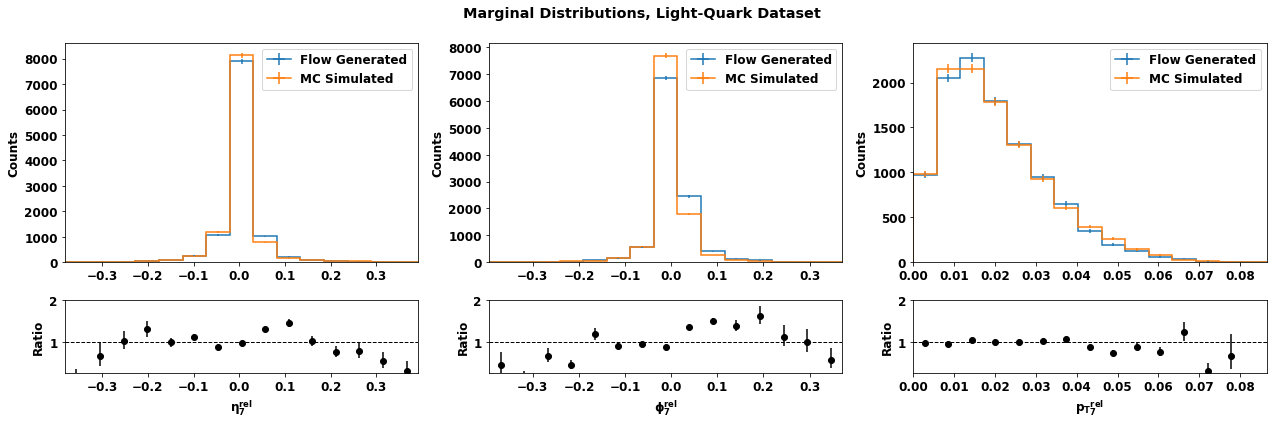

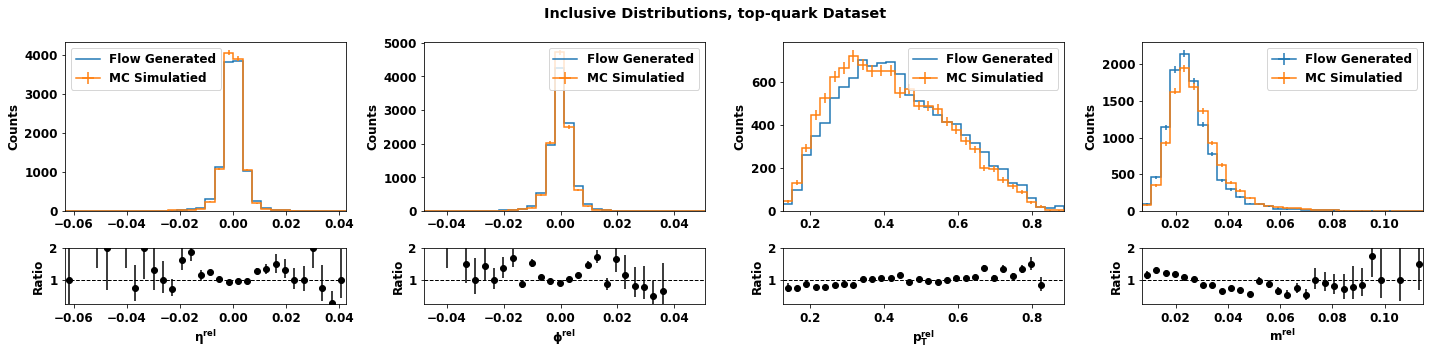

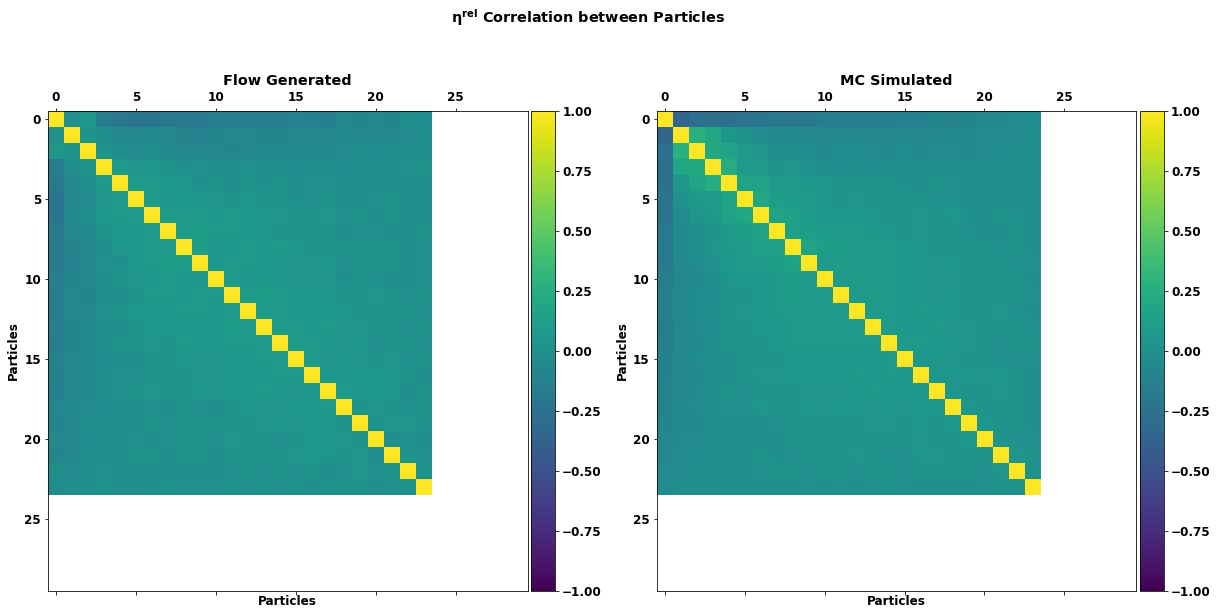

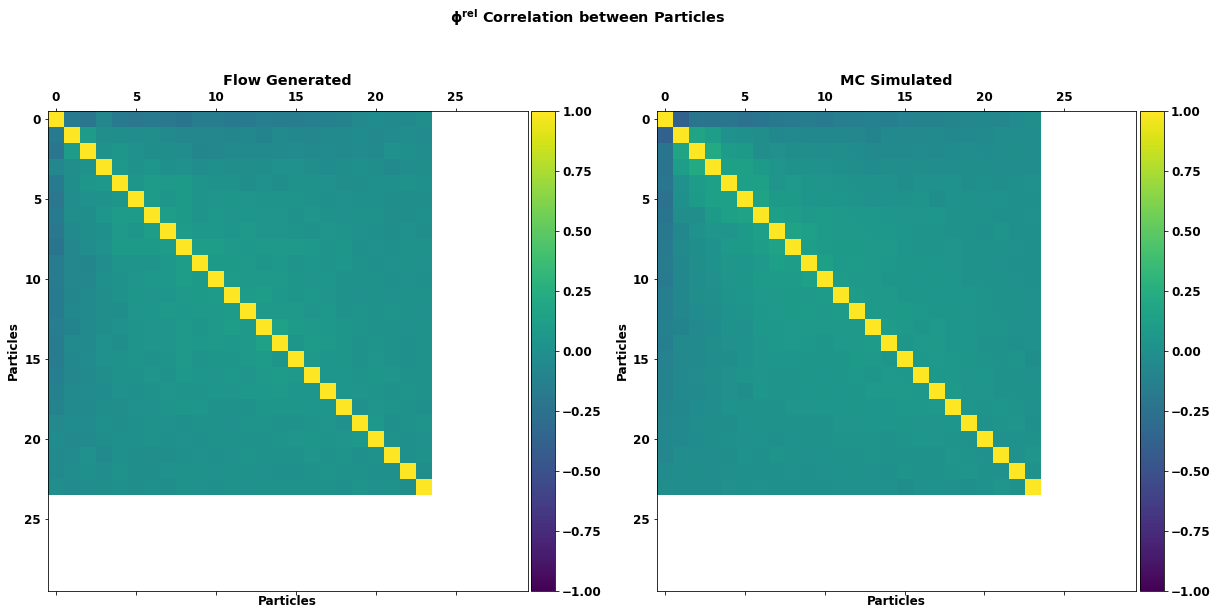

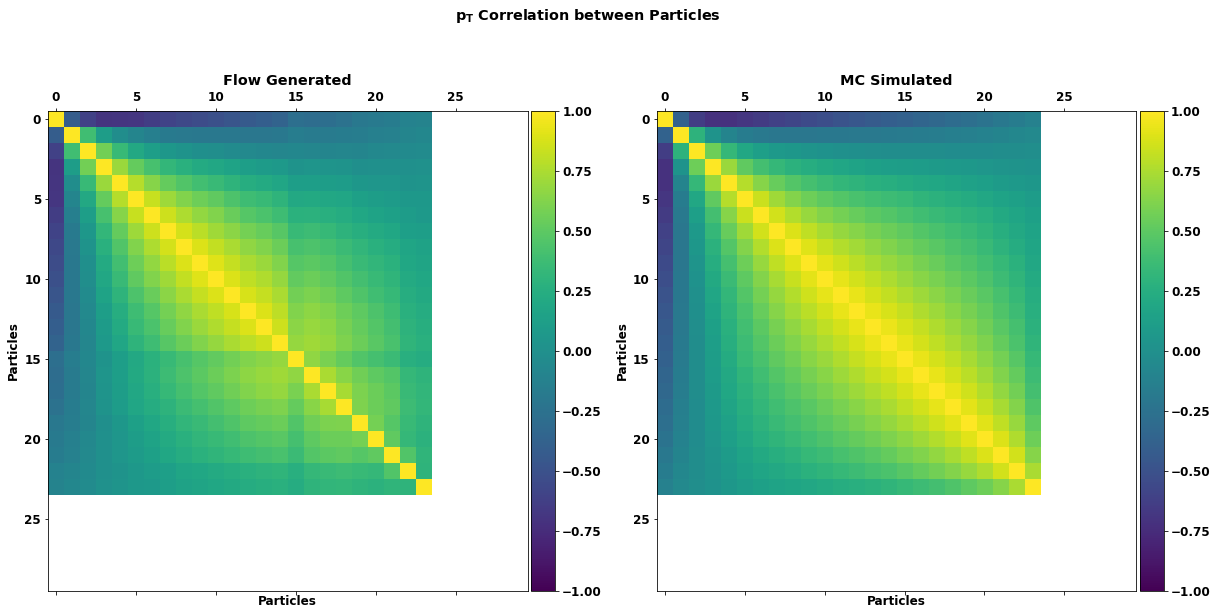

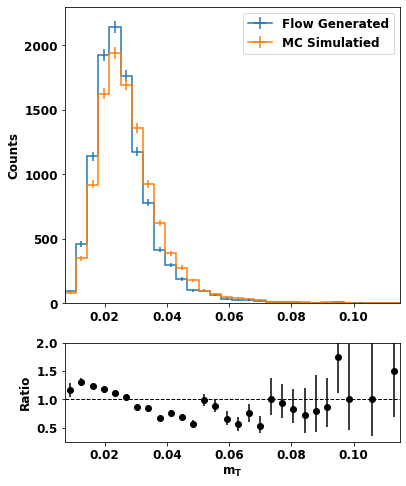

In [46]:

import matplotlib.pyplot as plt

p=parton
model.n_dim=90
k=5
fake_plot=fake_scaled[mask_test.sum(1)>k]
fake_plot=fake_plot*(~mask_test[mask_test.sum(1)>k].reshape(-1,30,1))
fake_scaled=fake_scaled*(~mask_test.reshape(-1,30,1))
true_scaled=true_scaled*(~mask.reshape(-1,30,1))

true=true_scaled[mask.sum(1)>k]
m_t=mass(true,(~mask[mask.sum(1)>k]))
m_gen=mass(fake_plot,(~mask_test[mask_test.sum(1)>k]))
plot=plotting_paper(model=model,gen=fake_plot.reshape(-1,90),true=true.reshape(-1,90),config=model.config,step=model.global_step,p=parton,logger=None)
plot.plot_marginals(ith=7,save=False,title="Marginal Distributions, {} Dataset".format("Top-Quark" if p=="t" else "Gluon" if p=="g" else "Light-Quark"))
plot.plot_mass(m_t.cpu().numpy(),m_gen.cpu().numpy(),save=False,bins=30,quantile=False,title="Inclusive Distributions, top-quark Dataset")
# plot.var_part(true=true[:,:model.n_dim],gen=test[:,:model.n_dim],true_n=n_true,gen_n=n_test,m_true=m_t,m_gen=m_test ,save=False)
plot.plot_corr(i=0,save=False)
plot.plot_corr(i=1,save=False)            
plot.plot_corr(i=2,save=False)     
plot.plot_mass_only(m_t.cpu().numpy(),m_gen.cpu().numpy(),bins=30)

In [1]:
print(w1m(fake_plot.reshape(-1,30,3),true.reshape(-1,30,3)))
fpnd(fake_scaled,"q")

NameError: name 'w1m' is not defined

In [4]:

import matplotlib.pyplot as plt
plt.figure()
_,bins,_=plt.hist(m_gen.numpy(),bins=50,alpha=0.5)
plt.hist(m_t.numpy(),bins=bins,alpha=0.5)
plt.savefig("masses")


NameError: name 'm_gen' is not defined

<Figure size 432x288 with 0 Axes>

In [43]:
m_t

tensor([49.6199, 14.1729, 38.2748,  ..., 20.4892, 17.0837, 75.0574])

In [53]:
def format_mean_sd(mean, sd):
    """round mean and standard deviation to most significant digit of sd and apply latex formatting"""
    decimals = -int(np.floor(np.log10(sd)))
    decimals -= int((sd * 10 ** decimals) >= 9.5)

    if decimals < 0:
        ten_to = 10 ** (-decimals)
        if mean > ten_to:
            mean = ten_to * (mean // ten_to)
        else:
            mean_ten_to = 10 ** np.floor(np.log10(mean))
            mean = mean_ten_to * (mean // mean_ten_to)
        sd = ten_to * (sd // ten_to)
        decimals = 0

    if mean >= 1e3 and sd >= 1e3:
        mean = np.round(mean * 1e-3)
        sd = np.round(sd * 1e-3)
        return f"${mean:.{decimals}f}$k $\\pm {sd:.{decimals}f}$k"
    else:
        return f"${mean:.{decimals}f} \\pm {sd:.{decimals}f}$"
print_table=results_sum.copy().drop("fpndnf",1)
print_table.index=["g","t"]#"q"
print_table["model"]=["g","t"]#"q"

print_table.loc[:,"w1m_"]*=1000
print_table.loc[:,"w1p_"]*=1000
print_table.loc[:,"w1efp_"]*=100000
print_table.loc[:,"pmm"]*=1000
print_table.loc[:,"pmp"]*=1000
print_table.loc[:,"pme"]*=100000
print_table.loc["MP-MP-g",:]=np.array([0.7,0.9,0.7,0.12,0.56,0.037,0.2,0.3,0.7,"MP-MP"])

print_table.loc["MPLFC-MP-g",:]=np.array([0.69,1.8,0.9,0.2,0.54,0.037,.07,.3,.2,"MP_LFC-MP"])
print_table.loc["MP-MP-q",:]=np.array([0.6,4.9,0.7,0.35,0.50,0.026,.2,.5,.4,"MP-MP"])

print_table.loc["MPLFC-MP-q",:]=np.array([0.7,2.6,0.9,0.08,0.52,0.037,.2,.4,.9,"MP_LFC-MP"])

print(print_table)

print_table.loc["MP-MP-t",:]=np.array([0.6,2.3,2,0.37,0.57,0.071,.2,.3,1,"MP-MP"])
print_table.loc["MPLFC-MP-t",:]=np.array([0.9,2.2,2,0.93,0.56,0.073,.3,.7,1,"MP_LFC-MP"])
print_table.loc[:,"w1m_"]=print_table.apply(lambda x:format_mean_sd(float(x["w1m_"]),float(x["pmm"])),axis=1)
print_table.loc[:,"w1efp_"]=print_table.apply(lambda x:format_mean_sd(float(x["w1efp_"]),float(x["pme"])),axis=1)
print_table.loc[:,"w1p_"]=print_table.apply(lambda x:format_mean_sd(float(x["w1p_"]),float(x["pmp"])),axis=1)


print_table.loc[:,"cov"]=print_table.loc[:,"cov"].astype(float).map('{:.2f}'.format)
print_table.loc[:,"fpndv"]=print_table.loc[:,"fpndv"].astype(float).map('{:.2f}'.format)
print_table.loc[:,"mmd"]=print_table.loc[:,"mmd"].astype(float).map('{:.3f}'.format)
print_table.loc[:,"pmm"]=print_table.loc[:,"pmm"].astype(float).map('{:,.2f}'.format)

print_table.loc[:,"pmp"]=print_table.loc[:,"pmp"].astype(float).map('{:,.2f}'.format)

print_table.loc[:,"pme"]=print_table.loc[:,"pme"].astype(float).map('{:,.2f}'.format)
print_table.loc[:,"parton"]=print_table.index.str[-1]
# print_table.loc[:,"val_w1m"]="$"+print_table["val_w1m"].map(str)+"\pm"+print_table["pmm"].map(str)+"$"
# print_table.loc[:,"val_w1p"]="$"+print_table["val_w1p"].map(str)+"\pm"+print_table["pmp"].map(str)+"$"
# print_table.loc[:,"val_w1efp"]="$"+print_table["val_w1efp"].map(str)+"\pm"+print_table["pme"].map(str)+"$"
print_table.loc[:,"cov"]="$"+print_table["cov"].map(str)+"$"
print_table.loc[:,"fpndv"]="$"+print_table["fpndv"].map(str)+"$"
print_table.loc[:,"mmd"]="$"+print_table["mmd"].map(str)+"$"

# print_table.loc[:,"model"]=print_table["model"].str.replace("c0","VNF").str.replace("cc","NFCC").str.replace("c","NFC").str.replace("1","\ (m)").str.replace("2","\ (m,n)").str.replace("q","").str.replace("g","").str.replace("t","")
index=["MP-MP-g","MPLFC-MP-g","g","MP-MP-t","MPLFC-MP-t","t"]#"MP-MP-q","MPLFC-MP-q","q"

print_table=print_table.loc[index,:]
final_table=pd.DataFrame()
tex=""
for p in ["g","t"]:#"q",
    temp=print_table[print_table["parton"]==p]

    for col in print_table.drop("model",axis=1).columns:
        
        if col not in ["w1m_","w1p_","w1efp_","fpndv","cov","mmd" ]:
            continue
        
        temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
        mins=temp_index==temp_index.min() if col!="cov" else temp_index==temp_index.max()
        temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,col].astype(str).str.replace("$","")+"}$"
    temp=temp[["model","w1m_","w1p_","w1efp_","fpndv","cov","mmd"]]
    temp.columns=["model","$W_1^M (\times 10^{-3})$","$W_1^P (\times 10^{-3})$","$W_1^{EFP}(\times 10^{-5})$","FPND",r"COV $\uparrow$","MMD"]
    text=temp.to_latex(index=False,escape=False)
    parton="Gluon" if p=="g" else "Light Quark" if p=="q" else "Top Quark"
    tex+="\multirow{7}{*}{"+parton+"} & "+text.split("MMD \\\\")[1].split("\\bottomrule")[0].replace("\\\\","\\\\&").replace("\\midrule","").replace("MP_LFC","MP\_LFC").replace("  ","")[:-2]+"\cline{1-8}" 
    tex+="\n"
print(tex)

    #     final_table=final_table.append(temp)

# print(final_table.to_latex(index=False,escape=False))


/tmp/ipykernel_159191/3634017143.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  print_table=results_sum.copy().drop("fpndnf",1)
/tmp/ipykernel_159191/3634017143.py:78: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
/tmp/ipykernel_159191/3634017143.py:80: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,col].astype(str).str.replace("$","")+"}$"


                 w1m_      w1p_     w1efp_        fpndv    cov       mmd  \
g            9.345149  7.875208  20.852531  1525.461049  0.043  0.349298   
t           13.892304   6.38091  82.737086   459.071231  0.062  0.347088   
MP-MP-g           0.7       0.9        0.7         0.12   0.56     0.037   
MPLFC-MP-g       0.69       1.8        0.9          0.2   0.54     0.037   
MP-MP-q           0.6       4.9        0.7         0.35    0.5     0.026   
MPLFC-MP-q        0.7       2.6        0.9         0.08   0.52     0.037   

                 pmm       pmp       pme      model  
g           0.244676  0.347244  2.571937          g  
t           0.476875  0.566082  4.705013          t  
MP-MP-g          0.2       0.3       0.7      MP-MP  
MPLFC-MP-g      0.07       0.3       0.2  MP_LFC-MP  
MP-MP-q          0.2       0.5       0.4      MP-MP  
MPLFC-MP-q       0.2       0.4       0.9  MP_LFC-MP  


/tmp/ipykernel_159191/3634017143.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,col].astype(str).str.replace("$","")+"}$"
/tmp/ipykernel_159191/3634017143.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  text=temp.to_latex(index=False,escape=False)
/tmp/ipykernel_159191/3634017143.py:78: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp

\multirow{7}{*}{Gluon} & 

MP-MP &$0.7 \pm 0.2$ & $\mathbf{0.9 \pm 0.3}$ &$\mathbf{0.7 \pm 0.7}$ & $\mathbf{0.12}$ & $\mathbf{0.56}$ & $\mathbf{0.037}$ \\&
MP\_LFC-MP & $\mathbf{0.69 \pm 0.07}$ &$1.8 \pm 0.3$ & $0.9 \pm 0.2$ &$0.20$ &$0.54$ & $\mathbf{0.037}$ \\&
g &$9.3 \pm 0.2$ &$7.9 \pm 0.3$ &$21 \pm 3$ & $1525.46$ &$0.04$ &$0.349$ \\\cline{1-8}
\multirow{7}{*}{Top Quark} & 

MP-MP & $\mathbf{0.6 \pm 0.2}$ &$2.3 \pm 0.3$ &$\mathbf{2 \pm 1}$ & $\mathbf{0.37}$ & $\mathbf{0.57}$ & $\mathbf{0.071}$ \\&
MP\_LFC-MP &$0.9 \pm 0.3$ & $\mathbf{2.2 \pm 0.7}$ &$\mathbf{2 \pm 1}$ &$0.93$ &$0.56$ &$0.073$ \\&
t & $13.9 \pm 0.5$ &$6.4 \pm 0.6$ &$83 \pm 5$ &$459.07$ &$0.06$ &$0.347$ \\\cline{1-8}



/tmp/ipykernel_159191/3634017143.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  text=temp.to_latex(index=False,escape=False)


Text(0.5, 0, 'number particles in jet')

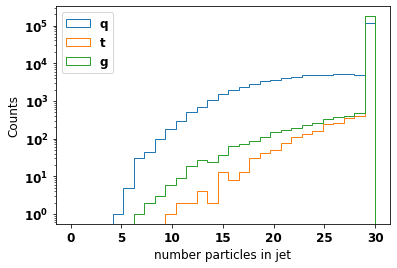

In [39]:
from jetnet_dataloader import JetNetDataloader
config["parton"]="q"
data_module_q=JetNetDataloader(config)
data_module_q.setup("validation")
config["parton"]="t"
data_module_t=JetNetDataloader(config)
data_module_t.setup("validation")
config["parton"]="g"
data_module_g=JetNetDataloader(config)
data_module_g.setup("validation")
_,bins,_=plt.hist(data_module_q.n,label="q",histtype="step",bins=np.linspace(0,30,30))
plt.hist(data_module_t.n,bins,label="t",histtype="step")
plt.hist(data_module_g.n,bins,label="g",histtype="step")
plt.legend(loc="upper left")

plt.yscale("log")
plt.ylabel("Counts")
plt.xlabel("number particles in jet")

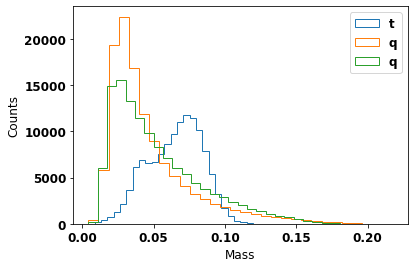

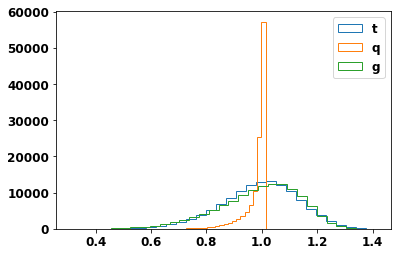

In [38]:
t=data_module_t.data[:,:90].reshape(-1,30,3)
mask_t=data_module_t.data[:,90:].bool()
t=model.scale(t,mask_t)
q=data_module_q.data[:,:90].reshape(-1,30,3)
mask_q=data_module_q.data[:,90:].bool()
q=model.scale(q,mask_q)
g=data_module_g.data[:,:90].reshape(-1,30,3)
mask_g=data_module_g.data[:,90:].bool()
g=model.scale(g,mask_g)
m=mass(t.reshape(-1,90),~mask_t)
plt.hist(m.numpy(),30,label="t",histtype="step")

m=mass(q.reshape(-1,90),~mask_q)
plt.hist(m.numpy(),30,label="q",histtype="step")

m=mass(g.reshape(-1,90),~mask_g)
plt.hist(m.numpy(),30,label="q",histtype="step")
plt.legend()
plt.xlabel("Mass")
plt.ylabel("Counts")
plt.show()

plt.hist(t.sum(axis=1).numpy()[:,2],30,label="t",histtype="step")
plt.hist(q.sum(axis=1).numpy()[:,2],30,label="q",histtype="step")
plt.hist(g.sum(axis=1).numpy()[:,2],30,label="g",histtype="step")
plt.legend()

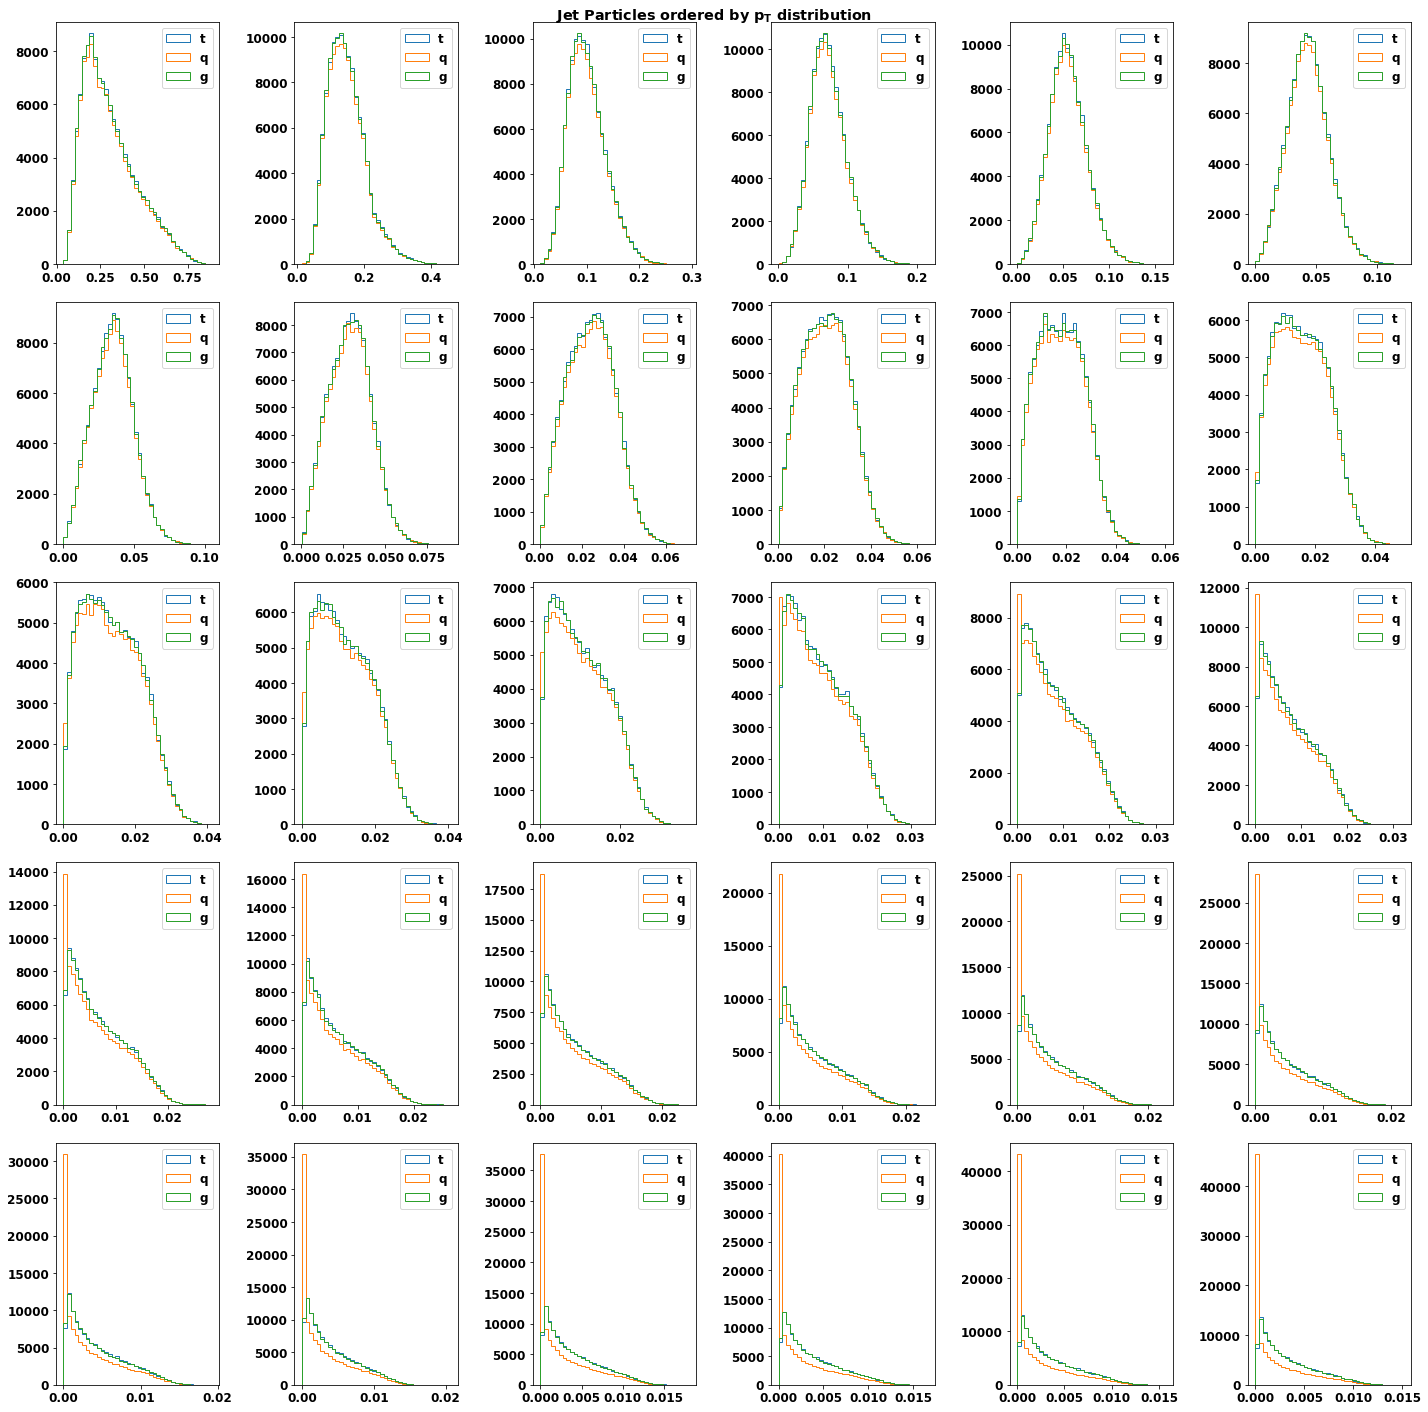

In [50]:
model.n_dim=3
t=data_module_t.data[:,:90].reshape(-1,30,3)
mask_t=data_module_t.data[:,90:].bool()
t=model.scale(t,mask_t)
q=data_module_q.data[:,:90].reshape(-1,30,3)
mask_q=data_module_q.data[:,90:].bool()
q=model.scale(q,mask_q)
g=data_module_g.data[:,:90].reshape(-1,30,3)
mask_g=data_module_g.data[:,90:].bool()
g=model.scale(g,mask_g)
fig,ax=plt.subplots(5,6,figsize=(20,20))
for i in range(30):
    _,bins,_=ax[i//6,i%6].hist(t[:,i,2].numpy(),bins=40,label="t",histtype="step")
    ax[i//6,i%6].hist(q[:,i,2].numpy(),bins=bins,label="q",histtype="step")
    ax[i//6,i%6].hist(g[:,i,2].numpy(),bins=bins,label="g",histtype="step")
    ax[i//6,i%6].legend()
plt.suptitle(r"Jet Particles ordered by $p_T$ distribution")
plt.tight_layout()

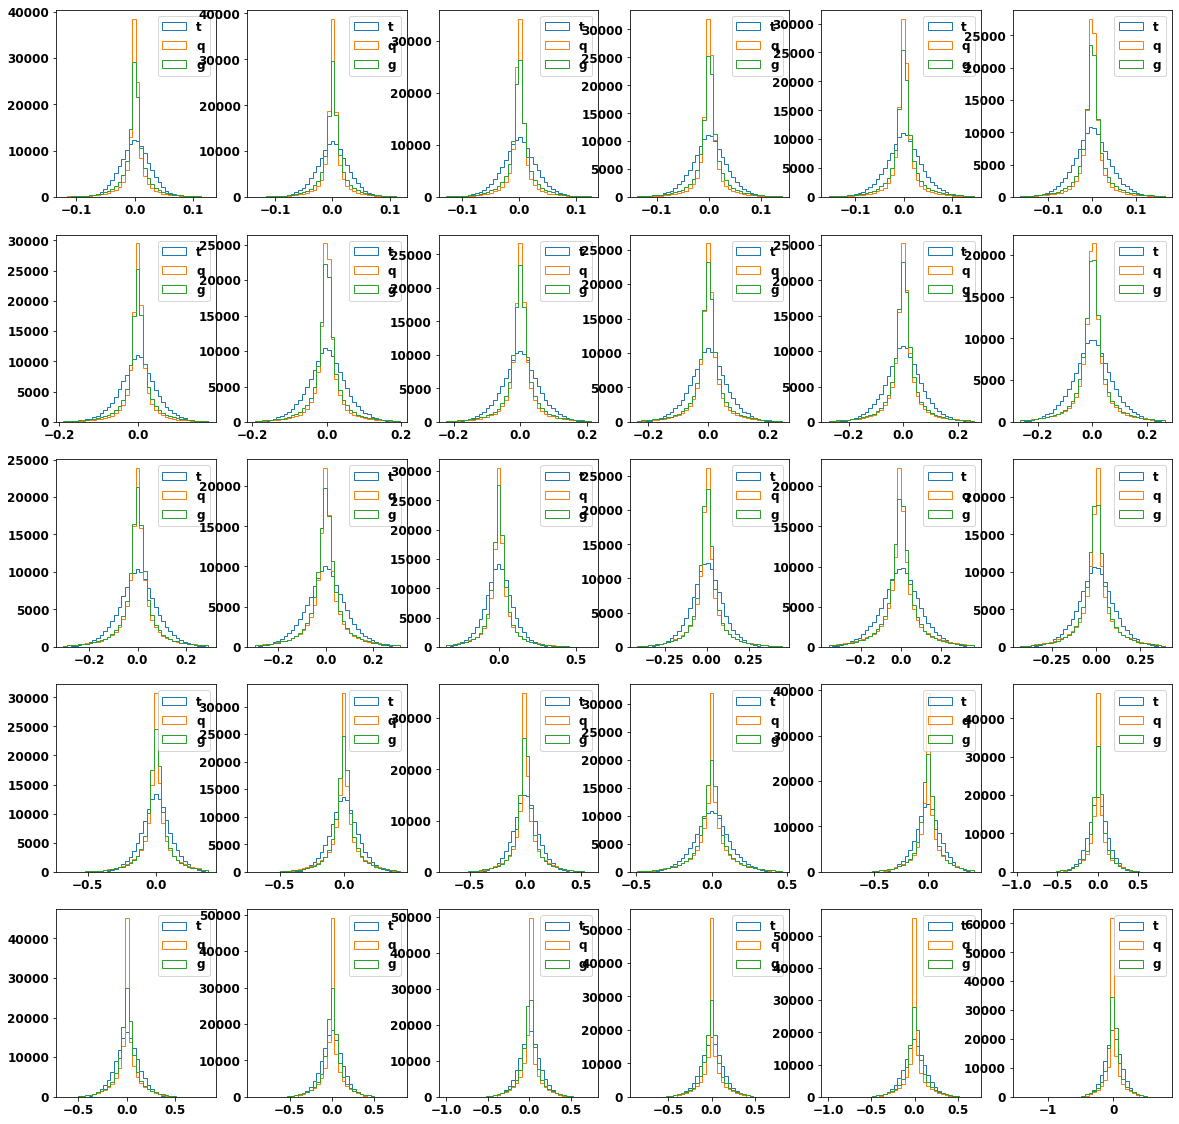

In [51]:
fig,ax=plt.subplots(5,6,figsize=(20,20))
for i in range(30):

    _,bins,_=ax[i//6,i%6].hist(t[:,i,0].numpy(),bins=40,label="t",histtype="step")
    ax[i//6,i%6].hist(q[:,i,0].numpy(),bins=bins,label="q",histtype="step")
    ax[i//6,i%6].hist(g[:,i,0].numpy(),bins=bins,label="g",histtype="step")
    ax[i//6,i%6].legend()
    

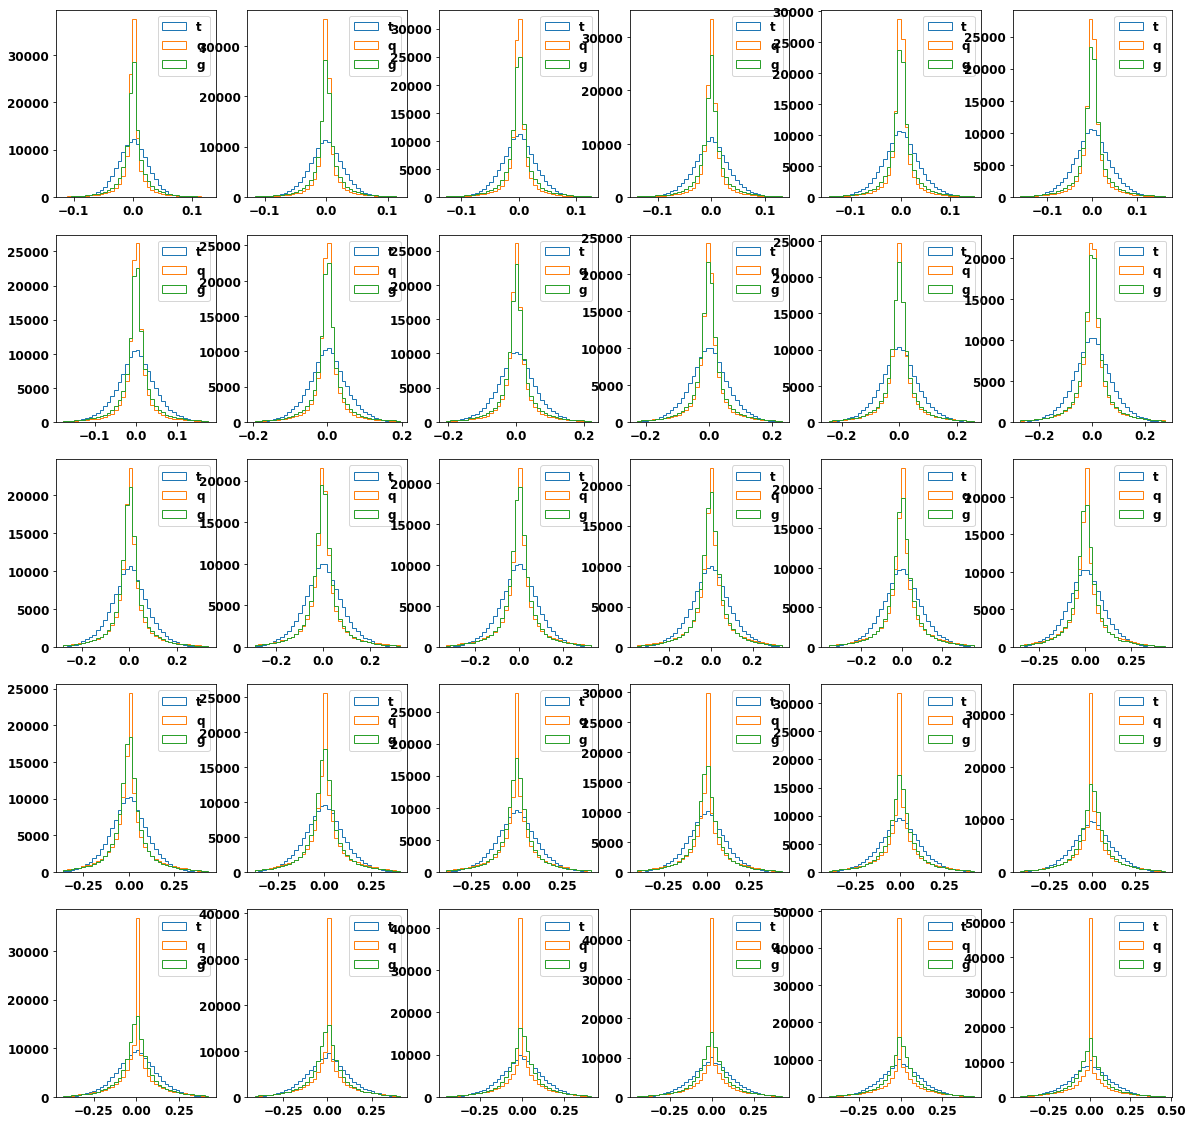

In [52]:
fig,ax=plt.subplots(5,6,figsize=(20,20))
for i in range(30):

    _,bins,_=ax[i//6,i%6].hist(t[:,i,1].numpy(),bins=40,label="t",histtype="step")
    ax[i//6,i%6].hist(q[:,i,1].numpy(),bins=bins,label="q",histtype="step")
    ax[i//6,i%6].hist(g[:,i,1].numpy(),bins=bins,label="g",histtype="step")
    ax[i//6,i%6].legend()
    

In [14]:
# df=pd.read_csv("/beegfs/desy/user/kaechben/{}/summary.csv".format("Transflow_working"))
# df1=pd.read_csv("/beegfs/desy/user/kaechben/{}/summary.csv".format("Transflow_reloaded"))
# df2=pd.read_csv("/beegfs/desy/user/kaechben/{}/summary.csv".format("Transflow_reloaded2"))
df=pd.read_csv("/beegfs/desy/user/kaechben/{}/summary.csv".format("Transflow_gettingthere_q"))
for name in ["Transflow_gettingthere_q","Transflow_gettingthere_t","Transflow_gettingthere_g",
            "Transflow_final_q","Transflow_final_t","Transflow_final_g"]:
    temp=pd.read_csv("/beegfs/desy/user/kaechben/{}/summary.csv".format(name))
    df=pd.concat((df,temp))
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.max_rows',None)
# df=df.append(df1).append(df2)
df.loc[:,"val_w1m"]*=1000
df.loc[:,"val_w1p"]*=1000
df.loc[:,"val_w1efp"]*=100000
df.loc[:,"val_w1m"]=df.loc[:,"val_w1m"].round(2)
df.loc[:,"val_cov"]=df.loc[:,"val_cov"].round(2)
df.loc[:,"val_fpnd"]=df.loc[:,"val_fpnd"].round(2)
df.loc[:,"val_mmd"]=df.loc[:,"val_mmd"].round(3)
df.loc[:,"val_w1p"]=df.loc[:,"val_w1p"].round(2)
df.loc[:,"val_w1efp"]=df.loc[:,"val_w1efp"].round(2)

df.sort_values("val_fpnd")[["path_index","val_w1m","val_w1p","val_w1efp","val_fpnd","val_cov","val_mmd"]]
#df=df[df.path_index.str.find("run17_08")>-1].sort_values("val_fpnd")
df.sort_values("val_fpnd")[["path_index","val_w1m","val_w1p","val_w1efp","val_fpnd","val_cov","val_mmd"]]

# best_q=df.iloc[2,:]


# df.iloc[302,:]


,path_index,val_w1m,val_w1p,val_w1efp,val_fpnd,val_cov,val_mmd
33,/beegfs/desy/user/kaechben/Transflow_final_g/run22_08-18_57_41_8/lightning_logs/version_0,1.30,1.42,1.220000e+00,2.000000e-01,0.53,0.037
41,/beegfs/desy/user/kaechben/Transflow_final_g/run22_08-18_57_41_59/lightning_logs/version_0,1.01,1.68,1.550000e+00,2.100000e-01,0.53,0.038
20,/beegfs/desy/user/kaechben/Transflow_final_g/run22_08-17_20_04_65/lightning_logs/version_0,0.83,1.33,8.800000e-01,2.400000e-01,0.52,0.038
42,/beegfs/desy/user/kaechben/Transflow_final_g/run22_08-18_57_41_43/lightning_logs/version_0,1.08,1.64,1.000000e+00,2.700000e-01,0.52,0.040
56,/beegfs/desy/user/kaechben/Transflow_final_t/run22_08-18_57_41_41/lightning_logs/version_0,1.69,1.17,5.250000e+00,3.100000e-01,0.57,0.076
...,...,...,...,...,...,...,...
0,/beegfs/desy/user/kaechben/Transflow_gettingthere_t/run29_08-19_11_56_9/lightning_logs/version_0,124.07,19470.59,2.189698e+12,3.082847e+07,0.02,21.699
15,/beegfs/desy/user/kaechben/Transflow_gettingthere_q/run29_08-19_11_56_87/lightning_logs/version_0,572442.95,179699.69,2.250251e+16,3.349821e+08,0.01,133.941
15,/beegfs/desy/user/kaechben/Transflow_gettingthere_q/run29_08-19_11_56_87/lightning_logs/version_0,572442.95,179699.69,2.250251e+16,3.349821e+08,0.01,133.941
11,/beegfs/desy/user/kaechben/Transflow_gettingthere_q/run29_08-19_11_56_32/lightning_logs/version_0,47.63,1221414.29,1.642062e+19,5.702699e+09,0.01,664.963


301


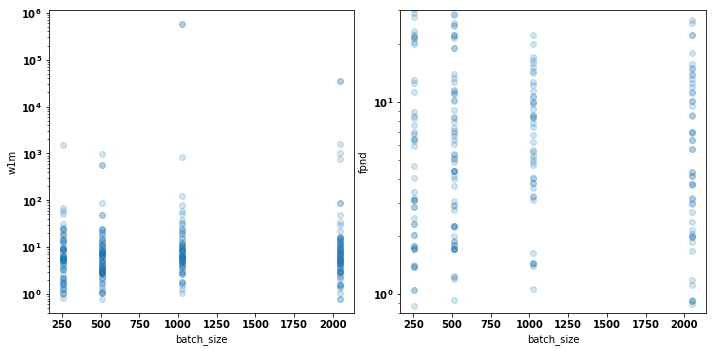

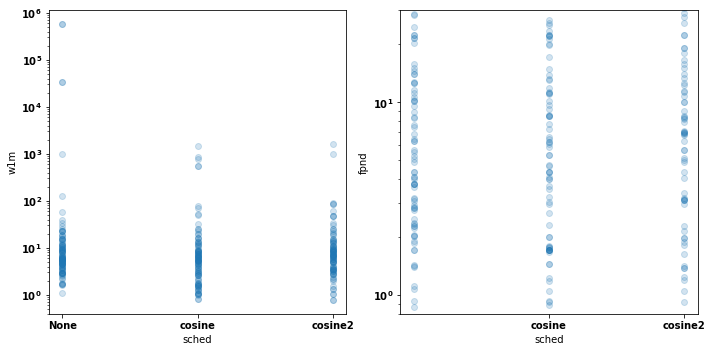

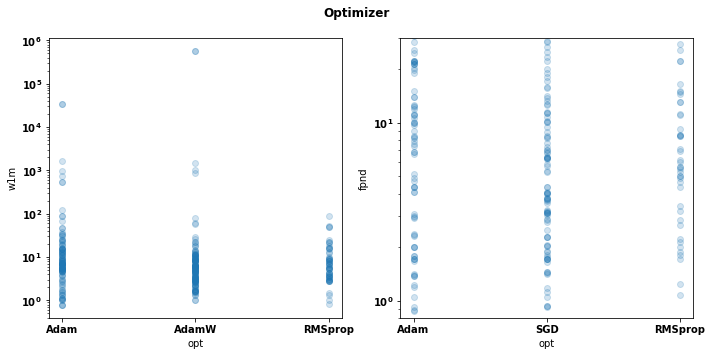

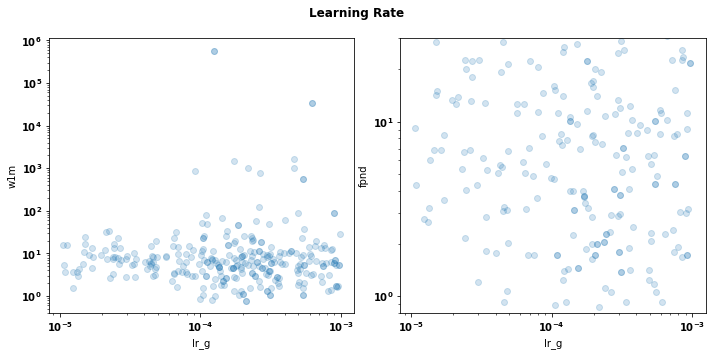

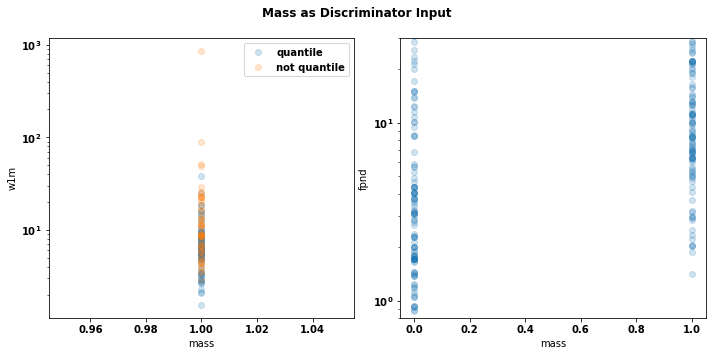

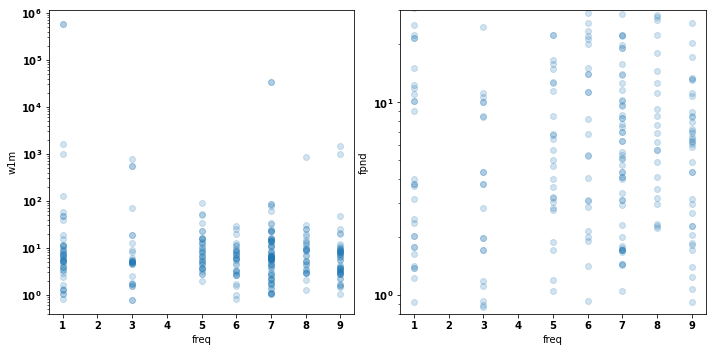

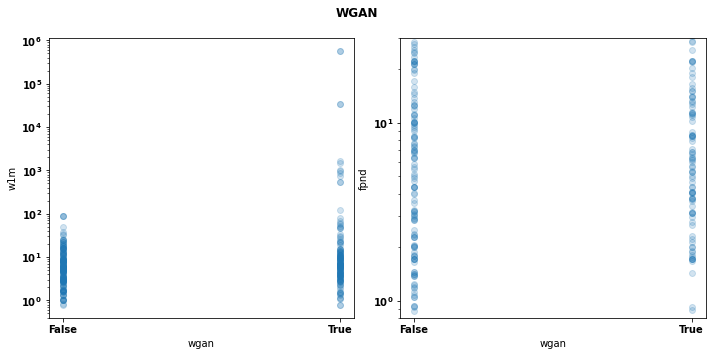

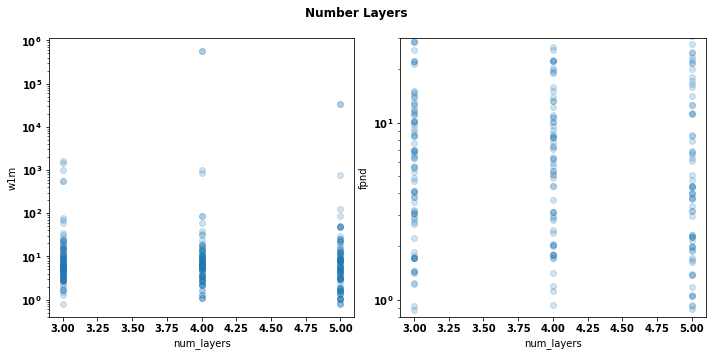

Traceback (most recent call last):
  File "/tmp/ipykernel_127933/4133221287.py", line 24, in <cell line: 11>
    ax[0].plot(df[key],df["val_w1m"],'o',alpha=0.2)
  File "/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 1634, in plot
    self.add_line(line)
  File "/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 2283, in add_line
    self._update_line_limits(line)
  File "/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 2306, in _update_line_limits
    path = line.get_path()
  File "/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/matplotlib/lines.py", line 999, in get_path
    self.recache()
  File "/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/matplotlib/lines.py", line 652, in recache
    x = _to_unmasked_float_array(xconv).ravel()
  File "/beegfs/desy/user/kaechb

no_hidden


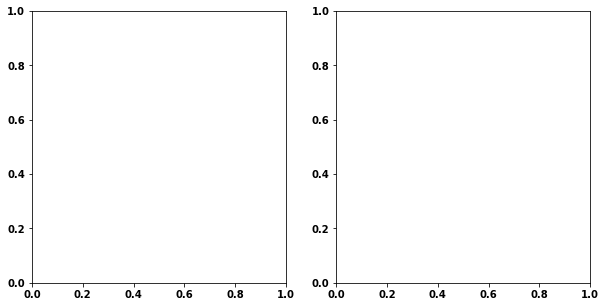

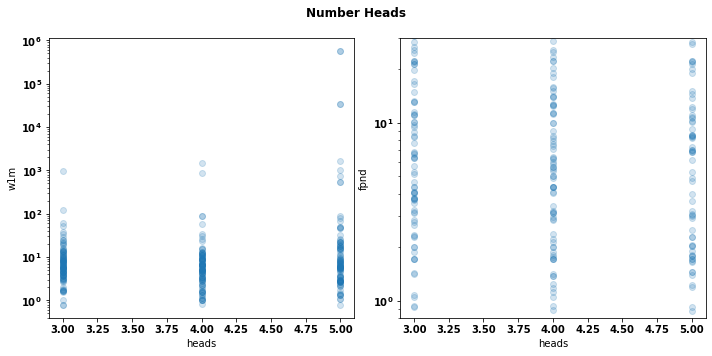

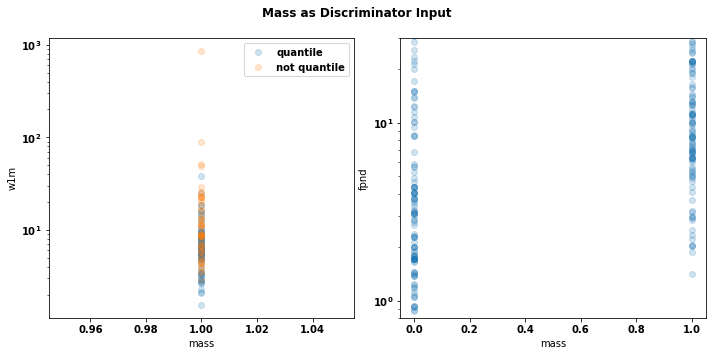

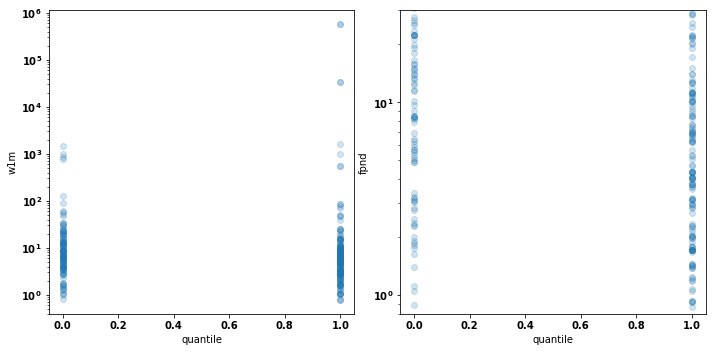

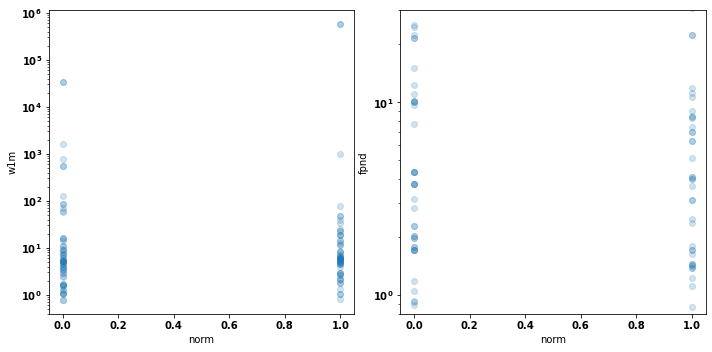

In [20]:
%matplotlib inline
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# df=backup[backup.mass==True]
# df=df[df.wgan==False]
# df=df[df.opt=="Adam"]
print(len(df))
for key in ["batch_size","sched","opt","lr_g","mass","freq","wgan","hidden","num_layers","no_hidden","heads","mass","quantile","norm"]:
    try:
        if len(df[key].value_counts())==1:
            continue
        fig,ax=plt.subplots(1,2,figsize=(10,5))
        df.loc[df["opt"]=="Adam","opt"]=0
        df.loc[df["opt"]=="AdamW","opt"]=1
        df.loc[df["opt"]=="RMSprop","opt"]=2
        df.loc[df["sched"]!=df["sched"],"sched"]=0
        df.loc[df["sched"]=="cosine","sched"]=1
        df.loc[df["sched"]=="cosine2","sched"]=2
        if not key=="mass":
            
            ax[0].plot(df[key],df["val_w1m"],'o',alpha=0.2)
        else:
            sel1=(df[key]==True)&(df["quantile"]==True)
            sel2=(df[key]==True)&(df["quantile"]==False)
            ax[0].plot(df[sel1][key],df[sel1]["val_w1m"],'o',alpha=0.2,label="quantile")
            ax[0].plot(df[sel2][key],df[sel2]["val_w1m"],'o',alpha=0.2,label="not quantile")
            ax[0].legend()
        plt.ylim(0.8,30)
        # plt.xlim(8,20)
        ax[0].set_yscale("log")
        if key in ["lr_g","lr_d"]:
            ax[0].set_xscale("log")
            plt.suptitle("Learning Rate")
        ax[0].set_xlabel(key)
        ax[0].set_ylabel("w1m")
        if key=="opt":
            ax[0].set_xticks([0,1,2])
            ax[0].set_xticklabels(["Adam","AdamW","RMSprop"])
        if key=="wgan":
            ax[0].set_xticks([0,1])
            ax[0].set_xticklabels([False,True])
            ax[1].set_xticks([0,1])
            ax[1].set_xticklabels([False,True])
        if key=="sched":
            ax[0].set_xticks([1,2])
            ax[0].set_xticklabels([
                "cosine","cosine2"])
        if key=="sched":
            ax[1].set_xticks([1,2])
            ax[1].set_xticklabels([
                "cosine","cosine2"])
        plt.xlabel(key)
        plt.ylabel("fpnd")
        ax[1].plot(df[key],df["val_fpnd"],'o',alpha=0.2)
        # plt.ylim(0.5,100)
        # plt.ylim(0.1,2)
        if key=="opt":
            ax[1].set_xticks([0,1,2])
            ax[1].set_xticklabels(["Adam","SGD","RMSprop"])
        if key=="wgan":
            ax[1].set_xticks([0,1])
            ax[1].set_xticklabels([False,True])
        if key=="sched":
            ax[0].set_xticks([0,1,2])
            ax[0].set_xticklabels(["None","cosine","cosine2"])
        if key in ["lr_g","lr_d"]:
            plt.xscale("log")
        # plt.xlim(8,20)
        # plt.xscale()
        if key=="opt":
            plt.suptitle("Optimizer",fontweight='bold')
        if key=="wgan":
            plt.suptitle("WGAN",fontweight='bold')
        plt.tight_layout()
        if key=="mass":
            plt.suptitle("Mass as Discriminator Input",fontweight='bold')
        if key=="lr_g":
            plt.suptitle("Learning Rate",fontweight='bold')
        if key=="hidden":
            plt.suptitle("Hidden Nodes",fontweight='bold')
        if key=="num_layers":
            plt.suptitle("Number Layers",fontweight='bold')
        if key=="heads":
            plt.suptitle("Number Heads",fontweight='bold')

        plt.tight_layout()


        plt.yscale("log")
        plt.show()
        # plt.ylim(0.1,5)
    except:
        import traceback
        traceback.print_exc()
        print(key)

[4, 3, 2, 1]